## GLM Energy Thresholds

This notebook demonstrates how to prune a GLM flash-group-event tree on an event energy threshold. The group and flash areas and energies are recalculated to be consistent with removal of the events below threshold in each flash.

The actual thresholding of the dataset is a single function call. Most of this notebook is a few examples of visualizing the effects of applying a threshold, illustrated with:
1. The largest flash in the dataset
2. The statistics of flashes as a function 

In [1]:
import numpy as np
import xarray as xr
from glmtools.io.glm import GLMDataset, discretize_2d_location
from glmtools.io.threshold import filter_to_energy

In [2]:
# %matplotlib widget
import matplotlib.pyplot as plt

In [3]:
from glmtools.test.common import get_sample_data_list
included_data = get_sample_data_list()
glm = GLMDataset(included_data[0])

In [4]:
threshes = (np.arange(4)+0.5)*1e-6
n_thresh = threshes.shape[0]

def calc_filtered():
    prune_dss = [filter_to_energy(glm, thresh) for thresh in threshes[:]]
    return prune_dss
    
prune_dss = calc_filtered()

In [5]:
plt.close('all')

In [6]:
def check_biggest_flash(thresh, glm):
    biggest_flash_id = glm.dataset.flash_id[glm.dataset.flash_area.argmax()].data
    one_flash = glm.get_flashes([biggest_flash_id])
    the_area = one_flash.flash_area.data[0]
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    hist_data = one_flash.event_energy.plot.hist(bins=np.arange(0,15e-6, 0.5e-6), ax=ax)
    ax.set_title(f'Flash {biggest_flash_id:}, Area {the_area:7.1f} for Thresh={thresh:3.1e}')

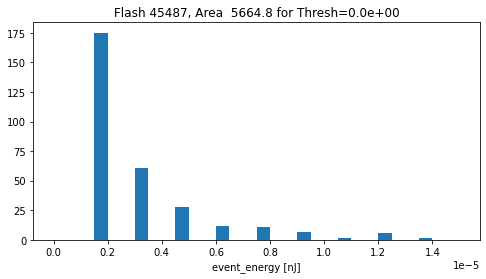

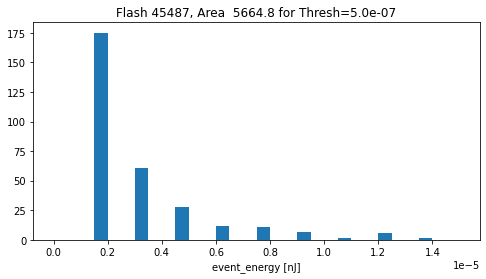

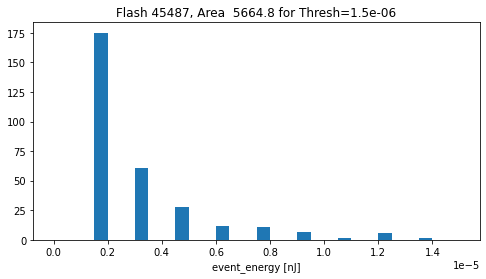

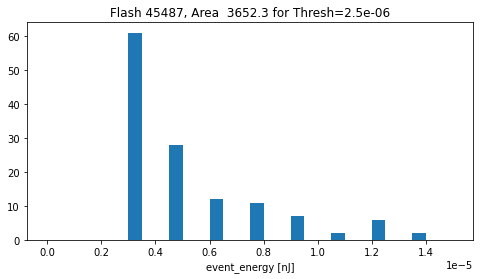

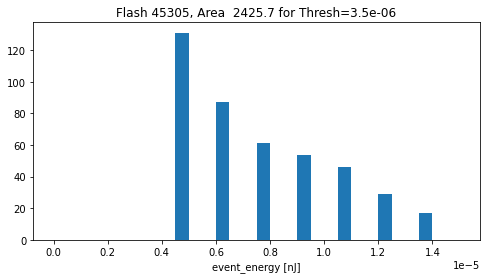

In [7]:
check_biggest_flash(0, glm)
for thresh, dsp in zip(threshes, prune_dss):
    check_biggest_flash(thresh, dsp)    

In [8]:
area_bins = (1.5**np.arange(14))*64.0
area_bin_ctr = (area_bins[1:] + area_bins[:-1]) / 2

# count_bins = 2**(np.arange(0,30,1)-0.5)
count_bins = np.arange(0,30,1)-0.5
count_bin_ctr = (count_bins[1:] + count_bins[:-1]) / 2
# print(count_bins)

flash_area_data = []
group_area_data = []
flash_count_data = []
group_count_data = []
event_count_data = []
flash_nevent_data = []
flash_ngroup_data = []

for thresh, gds in zip(threshes, prune_dss):
    ds = gds.dataset
    flash_area_data.append(np.histogram(ds['flash_area'].data, area_bins)[0])
    group_area_data.append(np.histogram(ds['group_area'].data, area_bins)[0])
    flash_nevent_data.append(np.histogram(ds['flash_child_event_count'].data, count_bins)[0])
    flash_ngroup_data.append(np.histogram(ds['flash_child_group_count'].data, count_bins)[0])
    
    flash_count_data.append(ds.dims['number_of_flashes'])
    group_count_data.append(ds.dims['number_of_groups'])
    event_count_data.append(ds.dims['number_of_events'])

    print('===', thresh*1e6, 'fJ ===')
    for k in ('number_of_events', 'number_of_groups', 'number_of_flashes'):
        print(k, ds.dims[k])

=== 0.5 fJ ===
number_of_events 21480
number_of_groups 7478
number_of_flashes 274
=== 1.5 fJ ===
number_of_events 21473
number_of_groups 7478
number_of_flashes 274
=== 2.5 fJ ===
number_of_events 14187
number_of_groups 5799
number_of_flashes 274
=== 3.5 fJ ===
number_of_events 8880
number_of_groups 4067
number_of_flashes 259


Text(0.5, 1.0, 'By threshold (fJ)')

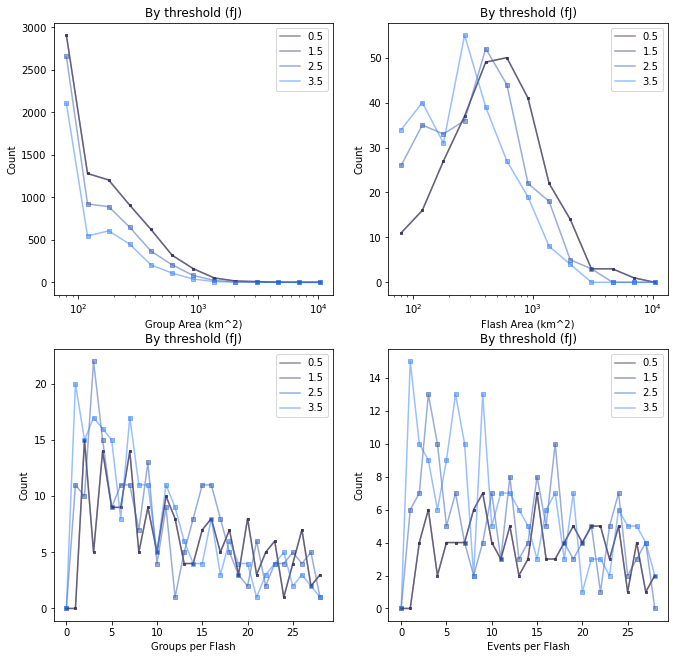

In [9]:
fig, ax = plt.subplots(2,2, figsize=(11,11))

max_thresh = max(threshes)
thresh_colors = [(0.2, 0.5*ti/max_thresh, ti/max_thresh) for ti in threshes]

alpha=0.5

for ti in range(n_thresh):
    ax[0,0].scatter(area_bin_ctr, group_area_data[ti], color=thresh_colors[ti], s=4e6*threshes[ti], marker='s', alpha=alpha)
    ax[0,0].plot(area_bin_ctr, group_area_data[ti], color=thresh_colors[ti], marker='', alpha=alpha)
ax[0,0].semilogx()
ax[0,0].legend(threshes*1.e6)
ax[0,0].set_xlabel('Group Area (km^2)')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('By threshold (fJ)')

for ti in range(n_thresh):
    ax[0,1].scatter(area_bin_ctr, flash_area_data[ti], color=thresh_colors[ti], s=4e6*threshes[ti], marker='s', alpha=alpha)
    ax[0,1].plot(area_bin_ctr, flash_area_data[ti], color=thresh_colors[ti], marker='', alpha=alpha)
ax[0,1].semilogx()
ax[0,1].legend(threshes*1.e6)
ax[0,1].set_xlabel('Flash Area (km^2)')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title('By threshold (fJ)')

for ti in range(n_thresh):
    ax[1,0].scatter(count_bin_ctr, flash_ngroup_data[ti], color=thresh_colors[ti], s=4e6*threshes[ti], marker='s', alpha=alpha)
    ax[1,0].plot(count_bin_ctr, flash_ngroup_data[ti], color=thresh_colors[ti], marker='', alpha=alpha)
# ax[1,0].semilogx()
ax[1,0].legend(threshes*1.e6)
ax[1,0].set_xlabel('Groups per Flash')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title('By threshold (fJ)')


for ti in range(n_thresh):
    ax[1,1].scatter(count_bin_ctr, flash_nevent_data[ti], color=thresh_colors[ti], s=4e6*threshes[ti], marker='s', alpha=alpha)
    ax[1,1].plot(count_bin_ctr, flash_nevent_data[ti], color=thresh_colors[ti], marker='', alpha=alpha)
# ax[1,1].semilogx()
ax[1,1].legend(threshes*1.e6)
ax[1,1].set_xlabel('Events per Flash')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title('By threshold (fJ)')